In [ ]:
# !pip install tqdm

# 스타벅스 매장 정보 수집
- 서울시 스타벅스 매장의 이름, 주소, 구 이름을 pandas dataframe으로 저장하기

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import time
import re

def fetch_starbucks():
    # 1. 크롬 옵션 설정
    options = webdriver.ChromeOptions()
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36")

    # 2. chromedriver 경로를 Service에 넘기기
    chrome_path = '../chromedriver-mac-x64/chromedriver'
    service = Service(executable_path=chrome_path)

    # 3. 드라이버 실행 (service 사용!)
    driver = webdriver.Chrome(service=service, options=options)
    driver.get('https://www.starbucks.co.kr/index.do')
    driver.maximize_window()

    # 4. 지역 검색 메뉴 접근
    time.sleep(1)
    action = ActionChains(driver)
    first_tag = driver.find_element(By.CSS_SELECTOR, '#gnb > div > nav > div > ul > li.gnb_nav03')
    second_tag = driver.find_element(By.CSS_SELECTOR, '#gnb > div > nav > div > ul > li.gnb_nav03 > div > div > div > ul:nth-child(1) > li:nth-child(3) > a')
    action.move_to_element(first_tag).move_to_element(second_tag).click().perform()

    # 5. 서울 클릭
    seoul_btn = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR,
        '#container > div > form > fieldset > div > section > article.find_store_cont > article > article:nth-child(4) > div.loca_step1 > div.loca_step1_cont > ul > li:nth-child(1) > a')))
    seoul_btn.click()

    # 6. 전체 클릭
    WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'set_gugun_cd_btn')))
    gu_buttons = driver.find_elements(By.CLASS_NAME, 'set_gugun_cd_btn')
    gu_buttons[0].click()

    # 7. 매장 리스트 로딩 대기
    WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'quickResultLstCon')))

    # 8. 파싱 시작
    req = driver.page_source
    soup = BeautifulSoup(req, 'html.parser')
    stores = soup.find('ul', class_='quickSearchResultBoxSidoGugun').find_all('li')

    store_list, addr_list, lat_list, lng_list = [], [], [], []

    for store in stores:
        store_list.append(store.find('strong').text.strip())
        addr_list.append(store.find('p').text.strip())
        lat_list.append(store['data-lat'])
        lng_list.append(store['data-long'])

    driver.quit()

    df = pd.DataFrame({
        'store': store_list,
        'addr': addr_list,
        'lat': lat_list,
        'lng': lng_list
    })

    return df


In [ ]:
starbucks_df = fetch_starbucks()

In [94]:
starbucks_df

,store,addr,lat,lng
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동)1522-3232,37.501087,127.043069
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동)1522-3232,37.510178,127.022223
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동)1522-3232,37.5139309,127.0206057
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동)1522-3232,37.499517,127.031495
4,대치재경빌딩,서울특별시 강남구 남부순환로 2947 (대치동)1522-3232,37.494668,127.062583
...,...,...,...,...
629,상봉역,서울특별시 중랑구 망우로 307 (상봉동)1522-3232,37.59689,127.08647
630,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층1522-3232",37.615368,127.076633
631,망우동,서울특별시 중랑구 망우로 407 (망우동)1522-3232,37.5995083771241,127.097538751682
632,양원역,서울특별시 중랑구 양원역로10길 3 (망우동)1522-3232,37.6066536267232,127.106359790053


In [ ]:
starbucks_df.to_csv('starbucks.csv')

# 이디야 매장 정보 수집
- 서울시 이디야커피 매장의 이름, 주소, 구 이름을 pandas dataframe으로 저장하기

In [73]:
seoul_districts = [
    "강남구", "강동구", "강북구", "강서구", "관악구", "광진구", "구로구", "금천구", "노원구", "도봉구",
    "동대문구", "동작구", "마포구", "서대문구", "서초구", "성동구", "성북구", "송파구", "양천구",
    "영등포구", "용산구", "은평구", "종로구", "중구", "중랑구"
]

In [ ]:
def fetch_ediya(input_list):
    ediya_url = 'https://ediya.com/'
    
    options = webdriver.ChromeOptions()
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36")
    
    chrome_path = '../chromedriver-mac-x64/chromedriver'
    service = Service(executable_path=chrome_path)

    driver = webdriver.Chrome(service=service, options=options)
    driver.get(ediya_url)
    driver.maximize_window()

    # 매장찾기
    time.sleep(1)
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'body > header > div > div > div.gnb_wrap > div.top_util > ul.top_members > li.store > a'))).click()

    # 주소탭
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#contentWrap > div.contents > div > div.store_search_pop > ul > li:nth-child(2) > a'))).click()
    
    # 주소 입력창 선택
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#keyword'))).click()
    
    # 매장정보를 담기 위한 빈 리스트
    store_list = []
    addr_list = []
    lat_list = []
    lng_list = []
    
    # 주소 입력
    for ele in tqdm(input_list):
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#keyword'))).click()
        driver.find_element(By.CSS_SELECTOR, '#keyword').clear()
        if ele == '중구':
            driver.find_element(By.CSS_SELECTOR, '#keyword').send_keys('서울 ' + ele)
        else:
            driver.find_element(By.CSS_SELECTOR, '#keyword').send_keys(ele)
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#keyword_div > form > button'))).click()
        
        # BeautifulSoup을 이용한 HTML 파싱
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '#placesList > li')))
        
        # 페이지가 갱신되었는지 확인
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, '#map > div:nth-child(1) > div > div:nth-child(6) > div:nth-child(1) > div > div > div.st_info_con > div.info_store_info > dl > dd:nth-child(1) > p')))
        test_ele = driver.find_element(By.CSS_SELECTOR, '#map > div:nth-child(1) > div > div:nth-child(6) > div:nth-child(1) > div > div > div.st_info_con > div.info_store_info > dl > dd:nth-child(1) > p')
        
        if test_ele.text == ele:           
            temp = driver.page_source
            soup = BeautifulSoup(temp, 'html.parser')
            stores = soup.find(id='placesList').find_all('li')
        else:
            time.sleep(2)
            temp = driver.page_source
            soup = BeautifulSoup(temp, 'html.parser')
            stores = soup.find(id='placesList').find_all('li')
        
        # 매장 정보 수집        
        for store in stores:            
            store_name = store.find('dl').find('dt').text
            addr = store.find('dl').find('dd').text
            map_raw = store.find('a').get('onclick')                       
            
            pattern = re.compile(r"panLatTo\((.+?),(.+?),(.+?)\)")
            if pattern.match(map_raw):
                lng = pattern.match(map_raw).group(1)
                lat = pattern.match(map_raw).group(2)
                
                lng = lng.split("'")[1]
                lng = float(lng)
                
                lat = lat.split("'")[1]
                lat = float(lat)
                
            store_list.append(store_name)
            addr_list.append(addr)
            lat_list.append(lat)
            lng_list.append(lng)
        print(f'{ele} 수집 완료')
       
    # 수집한 정보를 데이터 프레임으로 변환
    df = pd.DataFrame({
        'store': store_list,
        'addr': addr_list,
        'lat': lat_list,
        'lng': lng_list,
    })    
    
    driver.quit()

    return df

In [99]:
ediya_df = fetch_ediya(seoul_districts)

  4%|▍         | 1/25 [00:02<01:11,  2.96s/it]

강남구 수집 완료


  8%|▊         | 2/25 [00:05<00:59,  2.58s/it]

강동구 수집 완료


 12%|█▏        | 3/25 [00:07<00:53,  2.44s/it]

강북구 수집 완료


 16%|█▌        | 4/25 [00:10<00:54,  2.60s/it]

강서구 수집 완료


 20%|██        | 5/25 [00:13<00:52,  2.64s/it]

관악구 수집 완료


 24%|██▍       | 6/25 [00:15<00:47,  2.53s/it]

광진구 수집 완료


 28%|██▊       | 7/25 [00:17<00:44,  2.46s/it]

구로구 수집 완료


 32%|███▏      | 8/25 [00:20<00:40,  2.40s/it]

금천구 수집 완료


 36%|███▌      | 9/25 [00:22<00:40,  2.53s/it]

노원구 수집 완료


 40%|████      | 10/25 [00:25<00:36,  2.46s/it]

도봉구 수집 완료


 44%|████▍     | 11/25 [00:27<00:33,  2.41s/it]

동대문구 수집 완료


 48%|████▊     | 12/25 [00:29<00:30,  2.37s/it]

동작구 수집 완료


 52%|█████▏    | 13/25 [00:32<00:30,  2.50s/it]

마포구 수집 완료


 56%|█████▌    | 14/25 [00:34<00:26,  2.44s/it]

서대문구 수집 완료


 60%|██████    | 15/25 [00:37<00:23,  2.40s/it]

서초구 수집 완료


 64%|██████▍   | 16/25 [00:39<00:21,  2.37s/it]

성동구 수집 완료


 68%|██████▊   | 17/25 [00:41<00:18,  2.35s/it]

성북구 수집 완료


 72%|███████▏  | 18/25 [00:44<00:17,  2.49s/it]

송파구 수집 완료


 76%|███████▌  | 19/25 [00:46<00:14,  2.46s/it]

양천구 수집 완료


 80%|████████  | 20/25 [00:49<00:12,  2.56s/it]

영등포구 수집 완료


 84%|████████▍ | 21/25 [00:51<00:09,  2.48s/it]

용산구 수집 완료


 88%|████████▊ | 22/25 [00:54<00:07,  2.42s/it]

은평구 수집 완료


 92%|█████████▏| 23/25 [00:56<00:04,  2.38s/it]

종로구 수집 완료


 96%|█████████▌| 24/25 [00:58<00:02,  2.36s/it]

중구 수집 완료


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]

중랑구 수집 완료


In [100]:
ediya_df

,store,addr,lat,lng
0,강남YMCA점,서울 강남구 논현동,0.000000,0.000000
1,강남구청역아이티웨딩점,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...
552,중랑교차로점,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
553,중랑묵동점,서울 중랑구 공릉로 42 (묵동),37.614369,127.078289
554,중랑역점,서울 중랑구 망우로 198 (상봉동),37.614369,127.078289
555,중화동점,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


In [91]:
ediya_df.to_csv('ediya.csv')

# 데이터 분석
## 정말로 이디야 커피는 스타벅스 매장 근처에 위치해 있는가?
- 이디야 커피와 스타벅스의 매장 위치 상관성 분석

## 구별 스타벅스 & 이디야 매장 현황 비교
### 구별 스타벅스 & 이디야 매장 수 비교

In [8]:
import pandas as pd

starbucks_df = pd.read_csv('starbucks.csv')
ediya_df = pd.read_csv('ediya.csv')

In [10]:
# gu 컬럼에 자치구 정보 별도로 표시
starbucks_df['gu'] = starbucks_df['addr'].apply(lambda x: x.split()[1])
ediya_df['gu'] = ediya_df['addr'].apply(lambda x: x.split()[1])

# 각각의 브랜드 이름을 추가
starbucks_df['brand'] = '스타벅스'
ediya_df['brand'] = '이디야'

# 데이터프레임 병합
df = pd.concat([starbucks_df, ediya_df], ignore_index=True)
df

,Unnamed: 0,store,addr,lat,lng,brand,gu
0,0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동)1522-3232,37.501087,127.043069,스타벅스,강남구
1,1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동)1522-3232,37.510178,127.022223,스타벅스,강남구
2,2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동)1522-3232,37.513931,127.020606,스타벅스,강남구
3,3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동)1522-3232,37.499517,127.031495,스타벅스,강남구
4,4,대치재경빌딩,서울특별시 강남구 남부순환로 2947 (대치동)1522-3232,37.494668,127.062583,스타벅스,강남구
...,...,...,...,...,...,...,...
1186,552,중랑교차로점,서울 중랑구 동일로 683 (면목동),0.000000,0.000000,이디야,중랑구
1187,553,중랑묵동점,서울 중랑구 공릉로 42 (묵동),37.614369,127.078289,이디야,중랑구
1188,554,중랑역점,서울 중랑구 망우로 198 (상봉동),37.614369,127.078289,이디야,중랑구
1189,555,중화동점,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야,중랑구


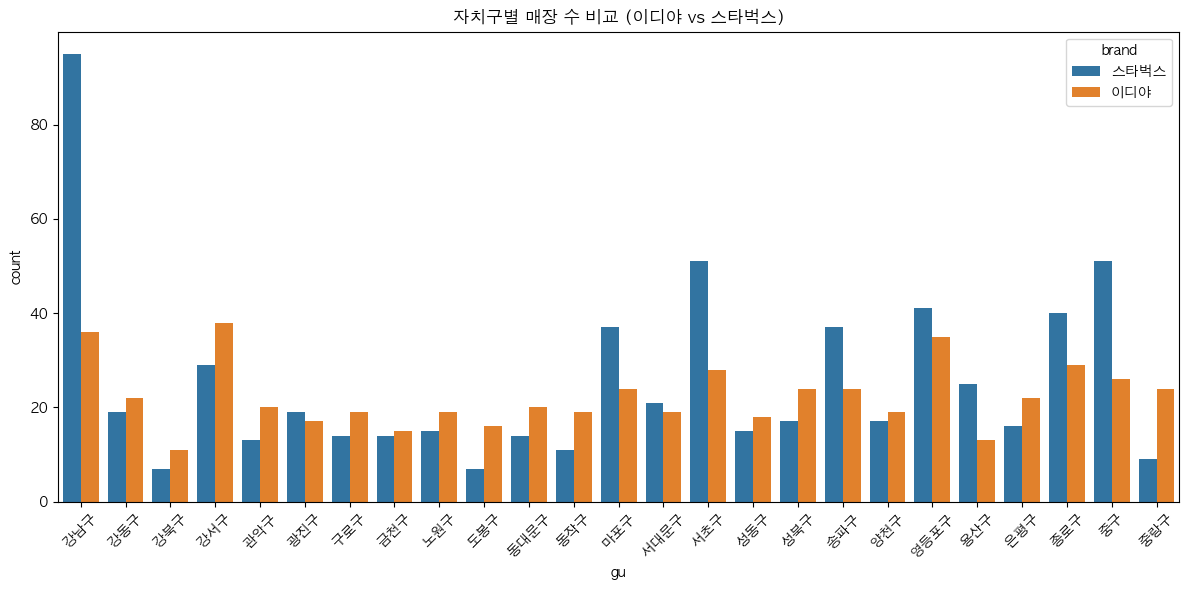

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 자치구별 매장 수 집계
gu_counts = df.groupby(['gu', 'brand']).size().reset_index(name='count')

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=gu_counts, x='gu', y='count', hue='brand')
plt.title('자치구별 매장 수 비교 (이디야 vs 스타벅스)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 상관관계 분석
- 자치구별로 매장 수가 비슷한 분포를 가지는지 corr()를 통해 상관관계 분석

In [13]:
starbucks_count = starbucks_df['gu'].value_counts().sort_index()
ediya_count = ediya_df['gu'].value_counts().sort_index()

df_compare = pd.DataFrame({'스타벅스': starbucks_count, '이디야': ediya_count})
print(df_compare.corr())  # 상관계수 확인

          스타벅스       이디야
스타벅스  1.000000  0.705655
이디야   0.705655  1.000000


### 이디야 & 스타벅스 매장 각각 히트맵 그리기 (Folium)

In [14]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# 스타벅스 히트맵
starbucks_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)
HeatMap(data=starbucks_df[['lat', 'lng']].values, radius=10).add_to(starbucks_map)
display(starbucks_map)

# 이디야 히트맵
ediya_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)
HeatMap(data=ediya_df[['lat', 'lng']].values, radius=10).add_to(ediya_map)
display(ediya_map)

## 거리 기반 분석
- 실제 두 브랜드 매장 간의 거리 분석
- 분석 방법: 이디야 매장 하나당 가장 가까운 스타벅스까지의 거리 계산 -> 해당 거리 데이터들의 평균 및 분포 확인

In [ ]:
# 거리 분석 데이터가 이상해서 확인해 보니 ediya_df에서 lon, lat 값이 0으로 들어가는 데이터들이 있었습니다. (재수집해도 동일하게 수집됨)
# 185건으로 적은 숫자는 아니지만 실제 거리 차이를 분석해야 하는 상황이므로 이 데이터는 제외시키고 진행하였습니다.

ediya_df = ediya_df[(ediya_df['lat'] > 1) & (ediya_df['lng'] > 1)]
print(f'제거 후 이디야 매장 수: {len(ediya_df)}')

제거 후 이디야 매장 수: 372


In [ ]:
from geopy.distance import geodesic

# 이디야 하나당 가장 가까운 스타벅스 거리 계산
closest_distances = []

for i, ediya in ediya_df.iterrows():
    ediya_loc = (ediya['lat'], ediya['lng'])
    distances = starbucks_df.apply(lambda sb: geodesic(ediya_loc, (sb['lat'], sb['lng'])).meters, axis=1)
    closest_distances.append(distances.min())

In [105]:
# 분석

import numpy as np
print(f'이디야 → 가장 가까운 스타벅스 거리 평균: {np.mean(closest_distances):.2f}m')
print(f'이디야 → 가장 가까운 스타벅스 거리 중간값: {np.median(closest_distances):.2f}m')

이디야 → 가장 가까운 스타벅스 거리 평균: 418.53m
이디야 → 가장 가까운 스타벅스 거리 중간값: 277.22m


In [118]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

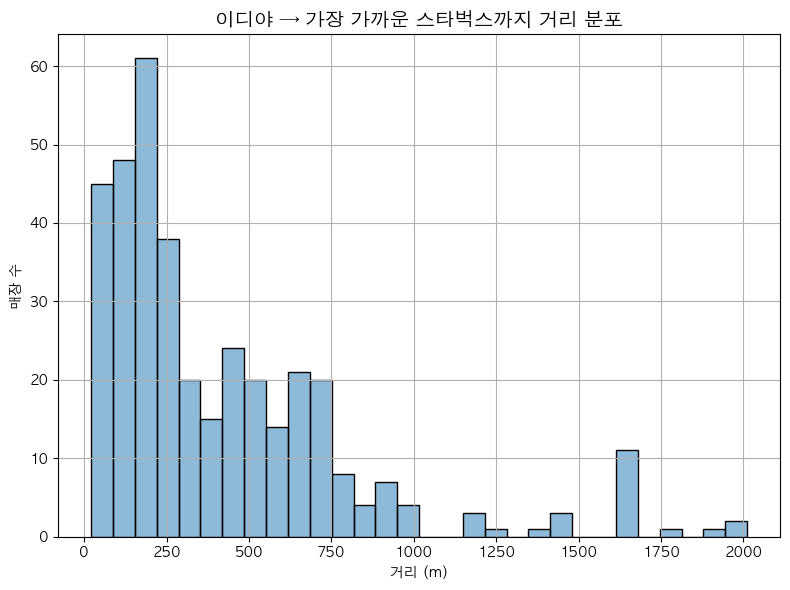

In [125]:
# 매장 간 거리분포를 히스토그램으로 확인

plt.figure(figsize=(8,6))
sns.histplot(closest_distances, bins=30, alpha=0.5)
plt.title('이디야 → 가장 가까운 스타벅스까지 거리 분포', fontsize=14)
plt.xlabel('거리 (m)')
plt.ylabel('매장 수')
plt.grid(True)
plt.tight_layout()
plt.show()

## 지도 시각화 (folium)

- 지도 시각화를 통해 눈으로 볼 수 있는 직관적인 분포 비교해 보기 (이디야: 파란색 / 스타벅스: 초록색)

In [ ]:
import folium
from IPython.display import display

# 지도 객체 만들기
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 스타벅스 매장 (초록)
for _, row in starbucks_df.iterrows():
    folium.CircleMarker(
        [row['lat'], row['lng']],
        radius=3,
        color='green',
        fill=True,
        fill_opacity=0.7,
        popup=row['store']
    ).add_to(m)

# 이디야 매장 (파랑)
for _, row in ediya_df.iterrows():
    folium.CircleMarker(
        [row['lat'], row['lng']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=row['store']
    ).add_to(m)

display(m)


### 클러스터 맵 <br>
- 마커의 개수가 많은 관계로 매장 분포를 지도상에 효과적으로 표현하기 위해 클러스터 맵 활용 <br>
- 매장이 몰려있는 지역 확인 가능

In [121]:
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

m_cluster = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 스타벅스 클러스터
sb_cluster = MarkerCluster(name='스타벅스').add_to(m_cluster)
for _, row in starbucks_df.iterrows():
    folium.Marker(
        [row['lat'], row['lng']],
        popup=row['store'],
        icon=folium.Icon(color='green', icon='coffee', prefix='fa')
    ).add_to(sb_cluster)

# 이디야 클러스터
ed_cluster = MarkerCluster(name='이디야').add_to(m_cluster)
for _, row in ediya_df.iterrows():
    folium.Marker(
        [row['lat'], row['lng']],
        popup=row['store'],
        icon=folium.Icon(color='blue', icon='coffee', prefix='fa')
    ).add_to(ed_cluster)

folium.LayerControl().add_to(m_cluster)
display(m_cluster)


### 특정 구만 보기 (예시: 강남구)

In [122]:
target_gu = '강남구'

# 주소에서 자치구 추출
starbucks_df['구'] = starbucks_df['addr'].apply(lambda x: x.split()[1])
ediya_df['구'] = ediya_df['addr'].apply(lambda x: x.split()[1])

# 필터링
sb_gangnam = starbucks_df[starbucks_df['구'] == target_gu]
ed_gangnam = ediya_df[ediya_df['구'] == target_gu]

m_gu = folium.Map(location=[37.4979, 127.0276], zoom_start=13)

for _, row in sb_gangnam.iterrows():
    folium.CircleMarker([row['lat'], row['lng']], radius=4, color='green', fill=True, fill_opacity=0.7).add_to(m_gu)

for _, row in ed_gangnam.iterrows():
    folium.CircleMarker([row['lat'], row['lng']], radius=4, color='blue', fill=True, fill_opacity=0.7).add_to(m_gu)

display(m_gu)

/var/folders/58/3cw891j1611448ndl98n2xw80000gn/T/ipykernel_41012/1954042750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ediya_df['구'] = ediya_df['addr'].apply(lambda x: x.split()[1])


### 스타벅스로부터 반경 500m 이내 매장만 시각화 (클릭 시 가까운 매장 정보 확인 가능)

In [123]:
from geopy.distance import geodesic

m_nearby = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

for _, ed in ediya_df.iterrows():
    ed_loc = (ed['lat'], ed['lng'])

    # 거리 500m 이내인 스타벅스가 하나라도 있으면 표시
    distances = starbucks_df.apply(lambda sb: geodesic(ed_loc, (sb['lat'], sb['lng'])).meters, axis=1)
    if distances.min() <= 500:
        folium.CircleMarker(
            ed_loc,
            radius=4,
            color='red',
            fill=True,
            fill_opacity=0.8,
            popup=f"{ed['store']} (가까운 스타벅스: {distances.min():.1f}m)"
        ).add_to(m_nearby)

display(m_nearby)

In [124]:
ratio = sum(np.array(closest_distances) <= 500) / len(closest_distances)
print(f"500m 이내 위치한 이디야 매장 비율: {ratio:.2%}")

500m 이내 위치한 이디야 매장 비율: 68.01%


## 분석 결과 요약

1. 자치구별 이디야 커피와 스타벅스 매장 수 상관관계 ✔

    📈 **상관계수: 0.71** <br>
    👉 **<mark>자치구별로 매장 분포가 매우 유사하다고 할 수 있음.</mark>** <br>


2. 실제 거리 기반 분석 결과 ✔

    1. 이디야 매장 하나 당 가장 가까운 스타벅스 매장과의 거리 분석 📍 <br>
        📏 평균 거리: 약 419m <br>
        📏 중간값 거리: 약 277m <br>
        👉 **<mark>이디야는 대체로 스타벅스에서 도보로 5분 내에 위치함.</mark>**

    2. 히스토그램 📍 <br>
        이디야 매장이 스타벅스 근처에 분포함을 시각적으로 확인할 수 있었음. <br>
        일부 먼 거리도 있지만, **많은 수의 이디야 매장들이 스타벅스로부터 200~500m 내에 위치함. (도보 3~5분 거리)**

3. 지도 기반 분석 결과 ✔ <br>

    스타벅스와 이디야가 서울 시내에 매우 유사하게 분포되어 있음을 직관적으로 확인 가능. <br>
    강남구 내에서도 스타벅스와 이디야 매장은 주요 상권을 중심으로 밀집해 있음. <br>
    약 68.01%의 이디야 매장이 스타벅스 반경 500m 내에 위치 → **<mark>입지 전략상 유사한 위치 타겟팅이 의심됨.</mark>** <br>

4. 결론 ✔ <br>

    분석 결과, 이디야 매장은 공간적으로 스타벅스 매장과 높은 입지 유사성을 보이며, <br>
    스타벅스 주변 상권을 공유하거나 후발 입지 전략을 채택하는 경향이 뚜렷하다. <br>
    이를 통해 프랜차이즈 입지 경쟁 전략, 브랜드별 상권 분석, 입지 추천 시스템 등에 활용 가능성을 기대할 수 있다.